In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pickle

## Load trees from results directory

In [56]:
results = sorted(glob.glob("../nextflow/results/*"))[-1]
results

'../nextflow/results/2022-05-04'

In [57]:
def gc_key(file):
    PR_str = file.split("/")[-2].split("-")
    return int(PR_str[1]), int(PR_str[3])

files = sorted(glob.glob(f"{results}/gctrees/PR*/gctree.p"), key=gc_key)
trees = {"_".join(f"{x}{y}" for x, y in zip(("mouse", "GC"), gc_key(file))): pickle.load(open(file, "rb"))
         for file in files}

print(f"loaded {len(trees)} GC trees")

loaded 77 GC trees


## Data frame with a row for each node on each tree, excluding 10-week mice

In [69]:
rows = []
for gc, tree in trees.items():    
    # hack: tree with all dist = 1, to get edge count distances between nodes
    tree_topo = tree.tree.copy(method="deepcopy")
    for node in tree_topo.traverse():
        if not node.is_root():
            node.dist = 1
        
    for node, node_topo in zip(tree.tree.traverse(), tree_topo.traverse()):            
            root_distance_nt = node.get_distance(tree.tree)
            root_distance_topo = node_topo.get_distance(tree_topo)

            descendant_distances_nt = [node.get_distance(descendant)
                                       for descendant in node.traverse()
                                       if descendant.abundance]
            descendant_distances_topo = [node_topo.get_distance(descendant)
                                         for descendant in node_topo.traverse()
                                         if descendant.abundance]
            
            assert all(x >= y for x, y in zip(descendant_distances_nt, descendant_distances_topo))
            
            closest_leaf_distance_nt = min(descendant_distances_nt)
            closest_leaf_distance_topo = min(descendant_distances_topo)
            farthest_leaf_distance_nt = max(descendant_distances_nt)
            farthest_leaf_distance_topo = max(descendant_distances_topo)
            
            if farthest_leaf_distance_topo == 0:
                assert farthest_leaf_distance_nt == 0, (gc, node.name, len(node.children), farthest_leaf_distance_nt)
            
            rows.append([gc,
                         node.name,
                         ";".join(node.mutations),
                         node.abundance,
                         len(node.children),
                         node.LBI,
                         root_distance_nt,
                         root_distance_topo,
                         closest_leaf_distance_nt,
                         closest_leaf_distance_topo,
                         farthest_leaf_distance_nt,
                         farthest_leaf_distance_topo,
                         node.delta_bind_CGG,
                         node.delta_expr,
                         node.delta_psr])

df = pd.DataFrame(rows, columns=["GC",
                                 "name",                        
                                 "aa_mutations",
                                 "abundance",
                                 "n_mutant_edges",
                                 "LBI",
                                 "root_distance_nt",
                                 "root_distance_topo",
                                 "closest_leaf_distance_nt",
                                 "closest_leaf_distance_topo",
                                 "farthest_leaf_distance_nt",
                                 "farthest_leaf_distance_topo",
                                 "delta_bind_CGG",
                                 "delta_expr",
                                 "delta_psr"])

# no 10-week mice
df = df.loc[~df.GC.str.startswith("mouse7") & ~df.GC.str.startswith("mouse8")]

df

,GC,name,aa_mutations,abundance,n_mutant_edges,LBI,root_distance_nt,root_distance_topo,closest_leaf_distance_nt,closest_leaf_distance_topo,farthest_leaf_distance_nt,farthest_leaf_distance_topo,delta_bind_CGG,delta_expr,delta_psr
0,mouse1_GC1,naive,,0,5,9.949465,0.0,0.0,1.0,1.0,12.0,6.0,0.00000,0.00000,0.00000
1,mouse1_GC1,seq37,Y103(H)F;S20(L)N;L116(L)P,1,0,1.163915,4.0,1.0,0.0,0.0,0.0,0.0,-0.06082,0.14827,-0.13364
2,mouse1_GC1,seq47,E51(H)G;Y52(H)F;Y66(L)N;V71(L)I;D74(L)A;Q95(L)...,1,0,1.000149,11.0,1.0,0.0,0.0,0.0,0.0,-3.45668,-1.05627,3.34321
3,mouse1_GC1,seq56,Y58(H)D,1,1,5.252151,1.0,1.0,0.0,0.0,2.0,1.0,-0.80796,-0.15104,-0.15010
4,mouse1_GC1,1,N40(H)H;N108(L)D;Y114(L)S;E125(L)Q,0,2,3.107390,4.0,1.0,3.0,1.0,5.0,1.0,-7.71074,-0.77924,2.61806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5574,mouse6_GC77,seq2,S57(H)N;S64(H)R;T65(H)I;L89(H)V;A105(H)G,3,1,2.630413,8.0,5.0,0.0,0.0,1.0,1.0,1.08960,-0.12466,-0.23740
5575,mouse6_GC77,seq25,S57(H)N;A40(L)G;Y42(L)H;T77(L)I,1,0,1.527961,9.0,5.0,0.0,0.0,0.0,0.0,0.75399,-0.72151,-0.37767
5576,mouse6_GC77,seq43,S57(H)N;A40(L)G;Y42(L)H;T77(L)I;S109(L)N,1,1,3.394974,8.0,5.0,0.0,0.0,2.0,1.0,0.71905,-0.86401,-0.35812
5577,mouse6_GC77,seq58,S57(H)N;S64(H)R;T65(H)I;L89(H)V;Y103(H)F;A105(H)G,1,0,1.599795,9.0,6.0,0.0,0.0,0.0,0.0,1.13203,-0.13537,0.10666


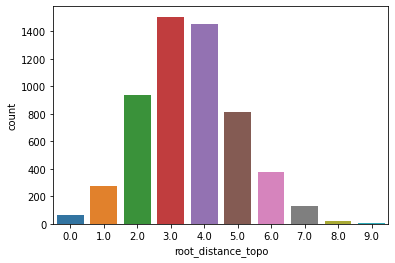

In [70]:
sns.countplot(data=df, x="root_distance_topo")
plt.show()

In [71]:
# df.to_csv("~/Downloads/node_data.csv", index=False)

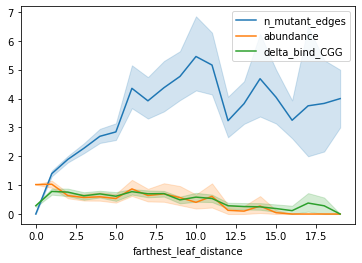

In [50]:
sns.lineplot(data=df, x="farthest_leaf_distance", y="n_mutant_edges", label="n_mutant_edges")
sns.lineplot(data=df, x="farthest_leaf_distance", y="abundance", label="abundance")
sns.lineplot(data=df, x="farthest_leaf_distance", y="delta_bind_CGG", label="delta_bind_CGG")
plt.ylabel("")
plt.show()